<a href="https://colab.research.google.com/github/Yati866/RealFakeNewsUsingEnsembleLearning/blob/main/FNCusingEnsemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import necessary Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import gensim
from gensim.models import Word2Vec
!pip install --upgrade keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from joblib import dump
from joblib import load
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load Dataset**

In [ ]:
fake = pd.read_csv("/content/gdrive/MyDrive/Fake and True/Fake.csv")
true = pd.read_csv("/content/gdrive/MyDrive/Fake and True/True.csv")

**Data Preprocesssing**

In [ ]:
#Counting by Subjects
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")

#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


In [ ]:
#Counting by Subjects
for key,count in true.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")

#Getting Total Rows
print(f"Total Records:\t{true.shape[0]}")

politicsNews:	11272
worldnews:	10145
Total Records:	21417


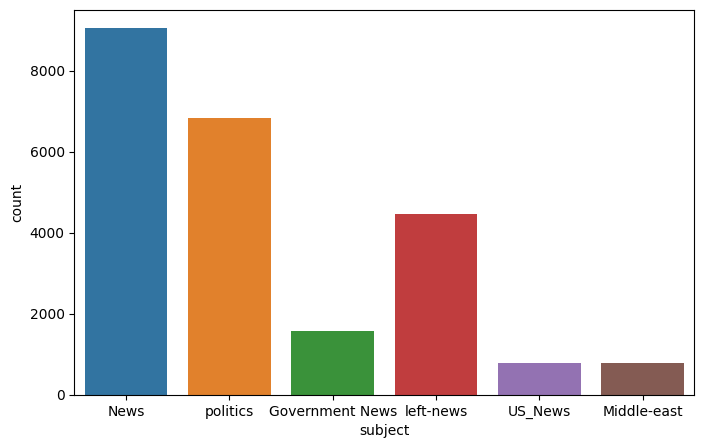

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=fake)
plt.show()


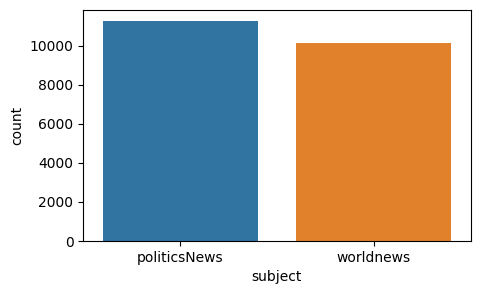

In [ ]:
plt.figure(figsize=(5,3))
sns.countplot(x="subject", data=true)
plt.show()


In [ ]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(true.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [ ]:
#Thus we have list of indices where publisher is not mentioned
#lets check
true.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [ ]:
true.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(true.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)

        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [ ]:
#Replace existing text column with new text
#add seperate column for publication info
true["publisher"] = publisher
true["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [ ]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0   The head of a conservative Republican faction...  politicsNews   
1   Transgender people will be allowed for the fi...  politicsNews   
2   The special counsel investigation of links be...  politicsNews   
3   Trump campaign adviser George Papadopoulos to...  politicsNews   
4   President Donald Trump called on the U.S. Pos...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [ ]:
#dropping this record
true = true.drop(8970, axis=0)

In [ ]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [ ]:
print(fake.shape)
print(true.shape)

(23481, 4)
(21416, 5)


In [ ]:
# Adding class Information
true["class"] = 1
fake["class"] = 0

In [ ]:
#Combining Title and Text
true["text"] = true["title"] + " " + true["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [ ]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
true = true.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)


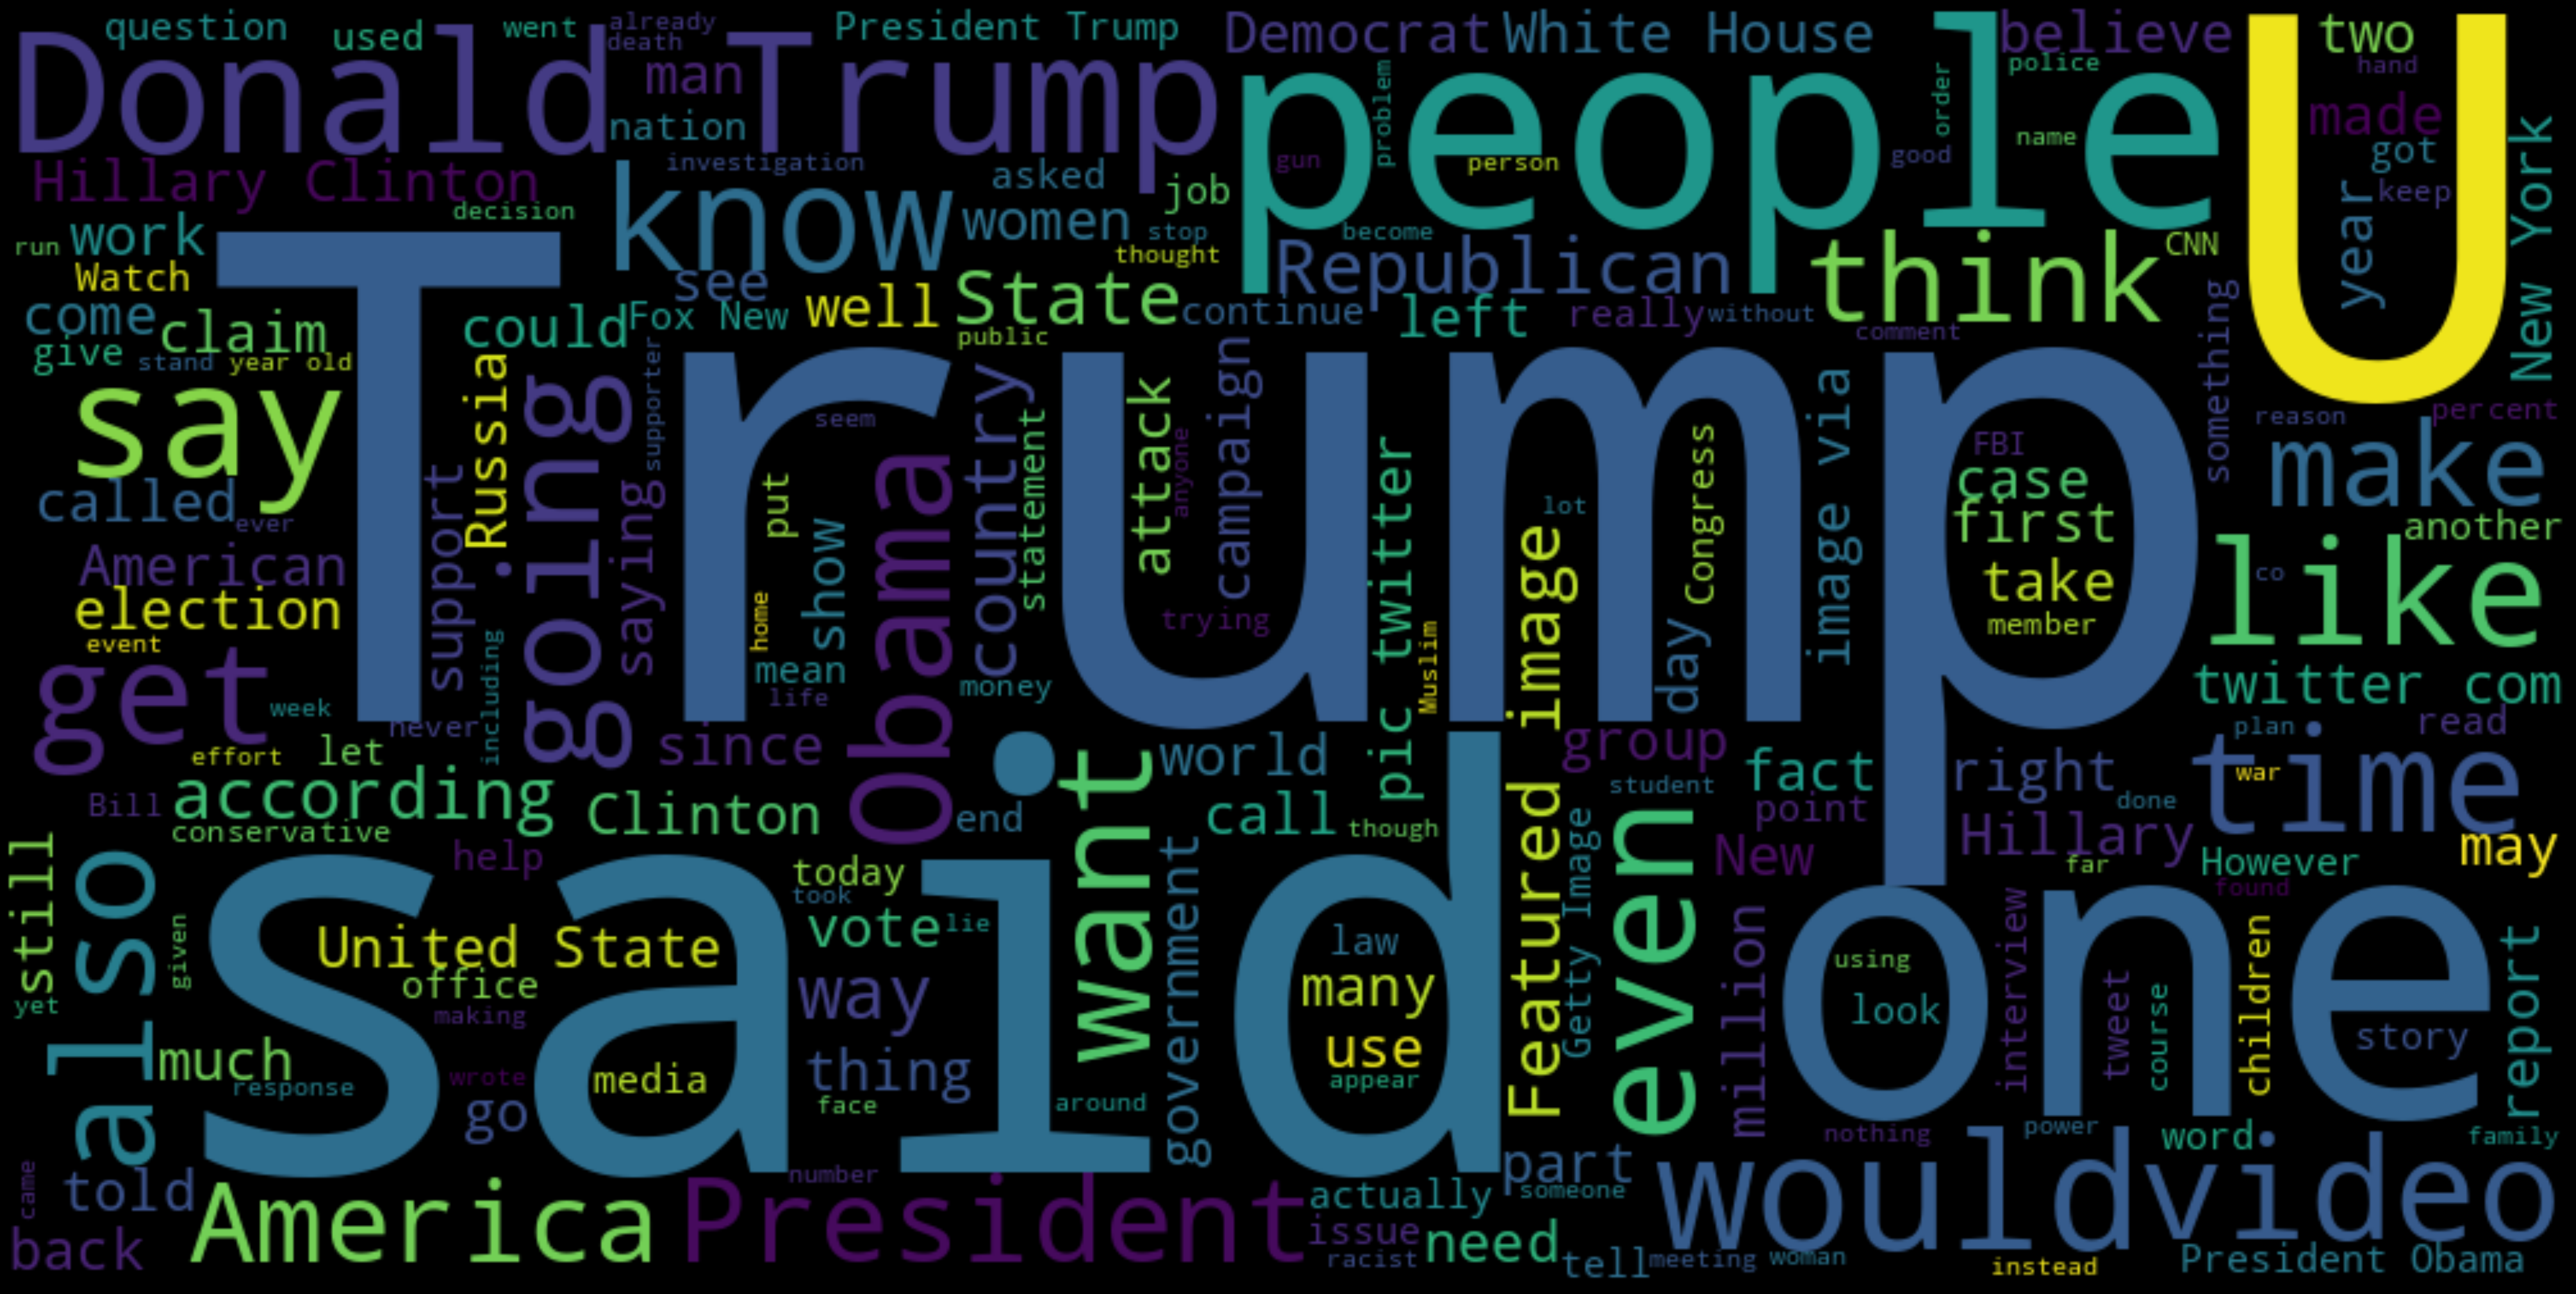

In [ ]:
#Word Cloud of Fake Dataset
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

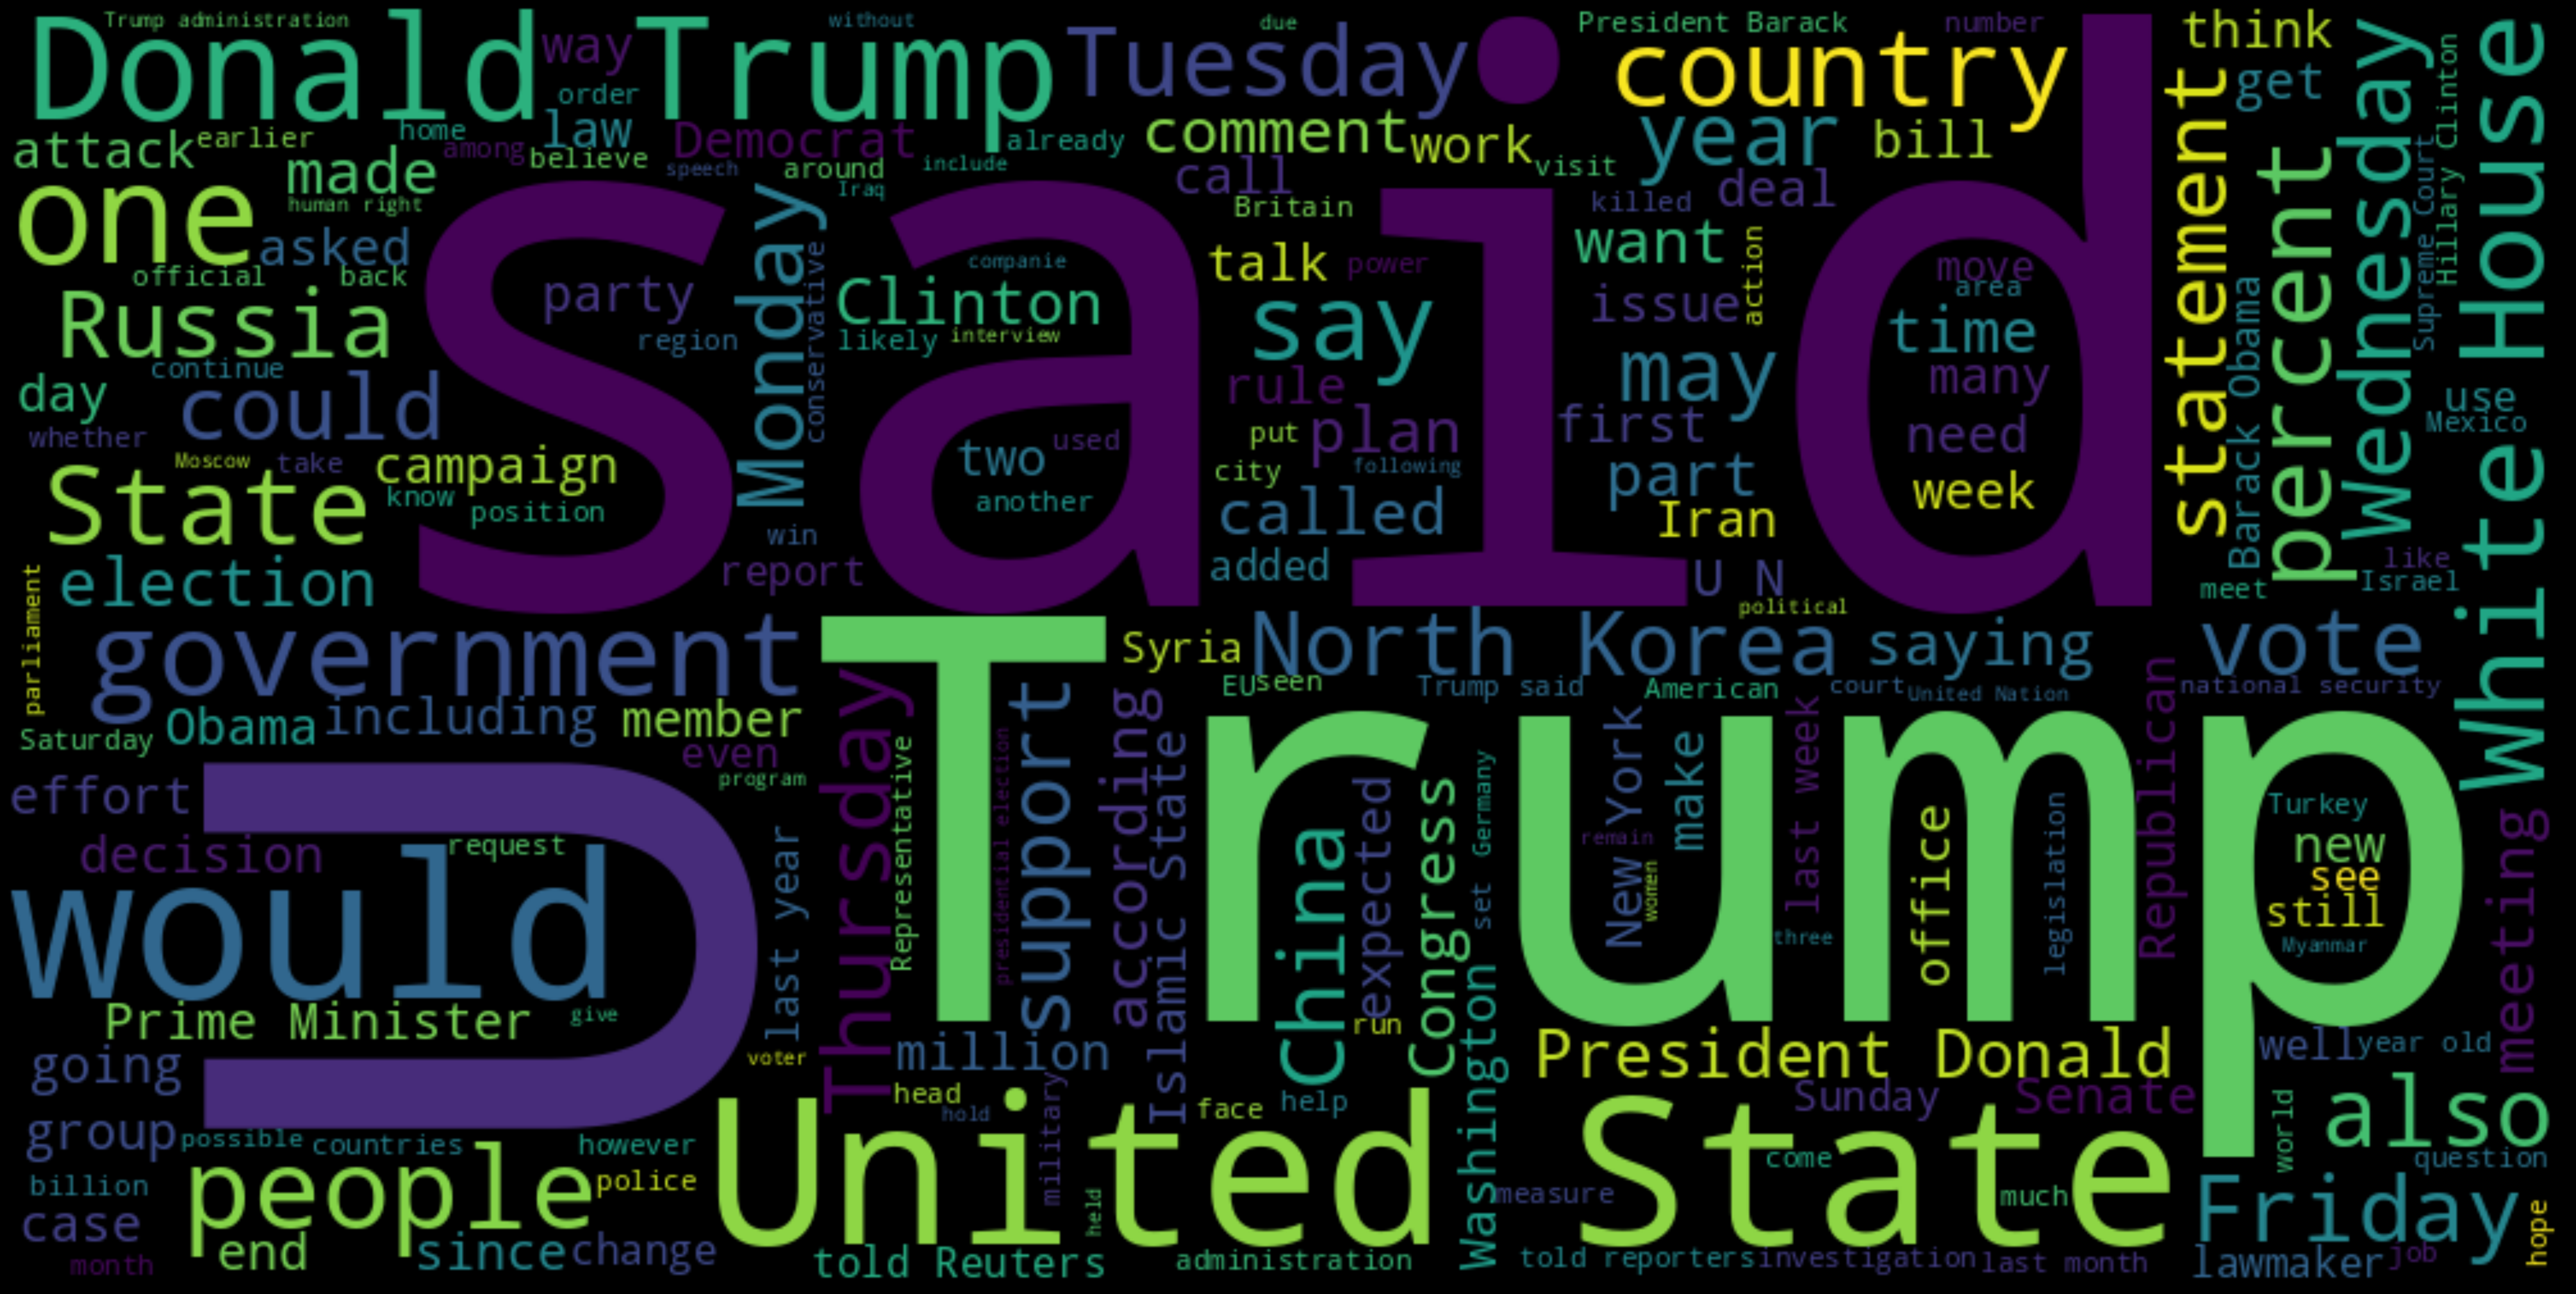

In [ ]:
#Word Cloud of Real Dataset
text = ''
for news in true.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
#Combining both into new dataframe
# data = true.append(fake, ignore_index=True)
data = pd.concat([fake,true],axis = 0,ignore_index=True)
data = data.sample(frac = 1,random_state=24).reset_index(drop=True)
del true, fake

In [ ]:
data.head(10)

text  class
0  Reforms aimed at making Pentagon acquisition m...      1
1  Fending off foes, Clinton blazes a trail with ...      1
2  Representative Conyers' future plans to be dis...      1
3  Putin says Russia will respond if Russian medi...      1
4  White House says it had no 'advance warning' o...      1
5  OBAMA PLAYS THE VICTIM CARD AGAIN: BALTIMORE R...      0
6   George Takei Just Lasered Trump With Some Per...      0
7  BUSTED? IT’S “HIGHLY LIKELY” THERE’S A BACK-UP...      0
8  Department of Homeland Security suspends flagg...      1
9   Obama Exposes Trump For The World To See, And...      0

In [ ]:
print(data.shape)

(44897, 2)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44897 entries, 0 to 44896
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44897 non-null  object
 1   class   44897 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.6+ KB


In [ ]:
# number of null values in each column
data.isnull().sum()

text     0
class    0
dtype: int64

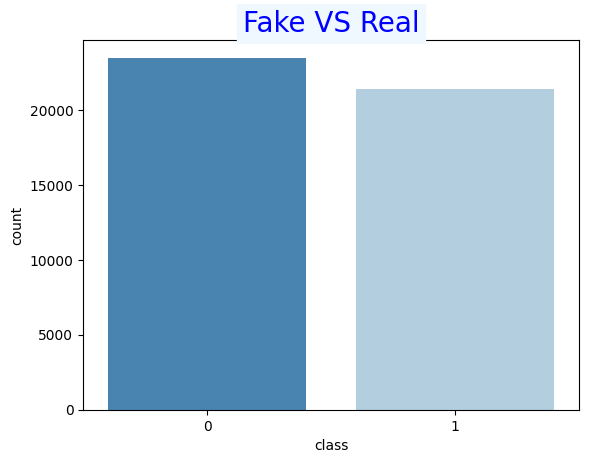

In [ ]:
chart=sns.countplot(x='class',data=data,palette='Blues_r')
plt.title("Fake VS Real",
          fontsize='20',
          backgroundcolor='aliceblue',
          color='blue');

In [ ]:
# Initialize stemmer and stop words
stemma = nltk.stem.porter.PorterStemmer()
stops = stopwords.words('english')

**Text preprocessing Step**

In [ ]:
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove non-alphabetic characters and stem the tokens
    tokens = [stemma.stem(token.lower()) for token in tokens if token.isalpha()]
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

In [ ]:
# Preprocess the text in the data frame
data['text'] = data['text'].apply(preprocess_text)

**Data Spliting using Train Test split**

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.25, random_state=42)

In [ ]:
X_train.shape

(33672,)

**Apply Random Forest,Logistic Regression and Gradient Boosting Model**

In [ ]:
# Load the necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Define the individual classifiers to be used in the ensemble
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42,learning_rate=0.1)
lr = LogisticRegression(random_state=42)

In [ ]:
# Define the individual classifiers to be used in the ensemble
rf1 = RandomForestClassifier(n_estimators=100, random_state=42)
gb1 = GradientBoostingClassifier(n_estimators=100, random_state=42,learning_rate=0.1)
lr1 = LogisticRegression(random_state=42)

**Create a Tfidf and Count vectorizer pipeline for making the data input in required format **

In [ ]:
# Define the pipeline for the text data processing
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

In [ ]:
from sklearn.decomposition import TruncatedSVD
# Define the pipeline for the text data processing
pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=300))
])

# Assuming X_train is your training data
X_train_transformed = pipeline.fit_transform(X_train)

In [ ]:
X_test_transformed = pipeline1.fit_transform(X_test)

In [ ]:
y_test.shape

(11225,)

In [ ]:
# Fit the pipeline to the training data
X_train_processed = pipeline.fit_transform(X_train)

In [ ]:
X_train_p = X_train_processed

In [ ]:
from sklearn.decomposition import TruncatedSVD

# create TruncatedSVD object with desired number of components
svd = TruncatedSVD(n_components=300)

# fit and transform the data X
X_svd = svd.fit_transform(X_train_p)

In [ ]:
X_svd.shape

(33672, 300)

**Fit the model**

In [ ]:
#Fit each individual model to the processed training data
lr1.fit(X_train_processed, y_train)

LogisticRegression(random_state=42)

In [ ]:
lr.fit(X_svd, y_train)

LogisticRegression(random_state=42)

In [ ]:
rf1.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf.fit(X_svd, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
gb1.fit(X_train_processed, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
gb.fit(X_svd, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Process the testing data using the fitted pipeline
X_test_processed = pipeline.transform(X_test)

In [ ]:
X_train_processed.shape

(33672, 148799)

In [ ]:
X_test_p = X_test_processed

In [ ]:
# create TruncatedSVD object with desired number of components
svd1 = TruncatedSVD(n_components=300)

# fit and transform the data X
X_svd1 = svd.fit_transform(X_test_p)

In [ ]:
print(X_svd1.shape)

(11225, 300)


In [ ]:
# Make predictions using each individual model
y_pred_rf1 = rf1.predict(X_test_processed)

In [ ]:
y_pred_gb1 = gb1.predict(X_test_processed)
# y_pred_gb = gb.predict(X_svd1)

In [ ]:
# y_pred_lr = lr.predict(X_svd1)
y_pred_lr1 = lr1.predict(X_test_processed)

In [ ]:
X_train_processed.shape

(33672, 148799)

In [ ]:
# # Calculate the individual accuracies
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_rf1 = accuracy_score(y_test, y_pred_rf1)

In [ ]:
# accuracy_gb = accuracy_score(y_test, y_pred_gb)
accuracy_gb1 = accuracy_score(y_test, y_pred_gb1)

In [ ]:
# accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr1 = accuracy_score(y_test, y_pred_lr1)

In [ ]:
# Print the individual accuracies
print(f'Random Forest Accuracy: {round(accuracy_rf1*100,2)}%')
print(f'Gradient Boosting Accuracy: {round(accuracy_gb1*100,2)}%')
print(f'Logistic Regression Accuracy: {round(accuracy_lr1*100,2)}%')

Random Forest Accuracy: 97.89%
Gradient Boosting Accuracy: 96.54%
Logistic Regression Accuracy: 98.08%


**Apply HARD voting classifier**

In [ ]:
# Define the ensemble model using hard voting
model_voting1 = VotingClassifier(
    estimators=[('rf1', rf1), ('gb1', gb1), ('lr1', lr1)],
    voting='hard'
)

In [ ]:
# Fit the ensemble model to the processed training data
model_voting1.fit(X_train_processed, y_train)

VotingClassifier(estimators=[('rf1', RandomForestClassifier(random_state=42)),
                             ('gb1',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr1', LogisticRegression(random_state=42))])

In [ ]:
# Process the testing data using the fitted pipeline
X_test_processed = pipeline.transform(X_test)

In [ ]:
# Make predictions using the ensemble model
y_pred = model_voting1.predict(X_test_processed)

In [ ]:
# Get the list of individual classifiers in the ensemble
classifiers = model_voting1.estimators_

# Make predictions using each individual classifier
predictions = [clf.predict(X_test_processed) for clf in classifiers]

# Combine the predictions into an array
predictions_array = np.array(predictions)

# Get the number of times each classifier's prediction matches the ensemble prediction
vote_counts = (predictions_array == y_pred.reshape(1, -1)).sum(axis=1)

# Calculate the percentage of votes for each classifier
vote_percentages = (vote_counts / len(y_pred) * 100).round(2)


# Print the percentage of votes for each classifier
for clf, pct in zip(classifiers, vote_percentages):
    print(f"{clf.__class__.__name__}: {pct}%")



RandomForestClassifier: 98.55%
GradientBoostingClassifier: 97.31%
LogisticRegression: 99.01%


In [ ]:
# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label= 0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, pos_label= 0)

In [ ]:
# Print the evaluation metrics
print('Accuracy:', accuracy*100)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 98.46770601336303
Precision: 0.9873724269157585
Recall: 0.9829516101257103
F1 Score: 0.9851570590265792


**Apply Soft Voting classifier**

In [ ]:
# Define the ensemble model using hard voting
model_voting2 = VotingClassifier(
    estimators=[('rf1', rf1), ('gb1', gb1), ('lr1', lr1)],
    voting='soft'
)

In [ ]:
# Fit the ensemble model to the processed training data
model_voting2.fit(X_train_processed, y_train)

VotingClassifier(estimators=[('rf1', RandomForestClassifier(random_state=42)),
                             ('gb1',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr1', LogisticRegression(random_state=42))],
                 voting='soft')

In [ ]:
# Make predictions using the ensemble model
y_pred_soft = model_voting2.predict(X_test_processed)

In [ ]:
# Calculate the evaluation metrics
accuracy_s = accuracy_score(y_test, y_pred_soft)
precision_s = precision_score(y_test,y_pred_soft, pos_label= 0)
recall_s = recall_score(y_test, y_pred_soft, pos_label=0)
f1_s = f1_score(y_test,y_pred_soft, pos_label= 0)

In [ ]:
# Print the evaluation metrics
print('Accuracy:', accuracy_s*100)
print('Precision:', precision_s)
print('Recall:', recall_s)
print('F1 Score:', f1_s)

Accuracy: 98.61024498886414
Precision: 0.9874072796273935
Recall: 0.9857069054589289
F1 Score: 0.9865563598759048


**Run on sample input to check the correctness of model**

In [ ]:
validate_text = '''Congress warranty expired, what guarantee can it give, asks PM Modi; slams party's promise of freebies:Prime Minister Narendra Modi
                   on Thursday said the Opposition's promises of freebies and appeasement politics is why states are drowning in debt.
                   “The Congress party itself is a promise of lies, corruption, nepotism. Forget guarantees, its warranty has expired long ago,” he added.'''


In [ ]:
Vd = preprocess_text(validate_text)

In [ ]:
Vd

'congress warranti expir guarante give ask pm modi slam parti promis freebiesprim minist narendra modi thursday said opposit promis freebi appeas polit whi state drown debt congress parti promis lie corrupt nepot forget guarante warranti ha expir long ago ad'

In [ ]:
Vd_transform = pipeline.transform([Vd])


In [ ]:
predicted_label = model_voting2.predict(Vd_transform)[0]


In [ ]:
if predicted_label==1:
  print("True News")
else:
  print("Fake News")

True News


In [ ]:
# Print the predicted label
print("Predicted Label:", predicted_label)

Predicted Label: 1


**Apply Sequential Model Like LSTM and GRU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

**Train Word2vec model**

In [ ]:
w2v_model = Word2Vec(X_train.apply(lambda x: x.split()).tolist(), vector_size=200, window=5, min_count=1, workers=4, sg=1)

In [ ]:
# Save the trained model to a file
w2v_model.save("word2vec.model")

In [ ]:
w2v_model = Word2Vec.load("word2vec.model")

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
max_len = 300

In [ ]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

(X_test_padded.shape)

(11225, 300)

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv.index_to_key:
        embedding_matrix[i] = w2v_model.wv[word]

**Apply GRU model to word2vec**

In [ ]:
# model_w2v = Sequential([
#     Embedding(len(tokenizer.word_index)+1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
#     GRU(units=128),
#     Dense(1, activation='sigmoid')
# ])
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.optimizers import Adam
def build_word2vec_model():
    model = Sequential([
        Embedding(len(tokenizer.word_index)+1, 200, weights=[embedding_matrix], input_length=max_len, trainable=False),
        GRU(units=128, return_sequences=False),
        # Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.save("wgru.h5")

     # print input shape
    print(f"Input shape: {model.input_shape}")

    # print output shape
    print(f"Output shape: {model.output_shape}")
    return model




In [ ]:
m = build_word2vec_model()

Input shape: (None, 300)
Output shape: (None, 1)


In [ ]:
# model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
word2vec_model = KerasClassifier(build_fn=build_word2vec_model, epochs=10)
m = build_word2vec_model()

Input shape: (None, 300)
Output shape: (None, 1)


In [ ]:
# model_w2v.summary()
history = word2vec_model.fit(X_train_padded, y_train,validation_split=0.3, epochs=10,batch_size = 256)

Input shape: (None, 300)
Output shape: (None, 1)
Epoch 1/10
93/93 [==============================] - 159s 2s/step - loss: 0.2519 - accuracy: 0.8975 - val_loss: 0.1580 - val_accuracy: 0.9405
Epoch 2/10
93/93 [==============================] - 173s 2s/step - loss: 0.1304 - accuracy: 0.9529 - val_loss: 0.1346 - val_accuracy: 0.9503
Epoch 3/10
93/93 [==============================] - 172s 2s/step - loss: 0.1025 - accuracy: 0.9647 - val_loss: 0.1142 - val_accuracy: 0.9612
Epoch 4/10
93/93 [==============================] - 171s 2s/step - loss: 0.0876 - accuracy: 0.9700 - val_loss: 0.0698 - val_accuracy: 0.9738
Epoch 5/10
93/93 [==============================] - 173s 2s/step - loss: 0.0560 - accuracy: 0.9810 - val_loss: 0.0527 - val_accuracy: 0.9813
Epoch 6/10
93/93 [==============================] - 172s 2s/step - loss: 0.0427 - accuracy: 0.9862 - val_loss: 0.0664 - val_accuracy: 0.9766
Epoch 7/10
93/93 [==============================] - 174s 2s/step - loss: 0.0387 - accuracy: 0.9866 - val_

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# print(word2vec_model.history.history.keys())
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


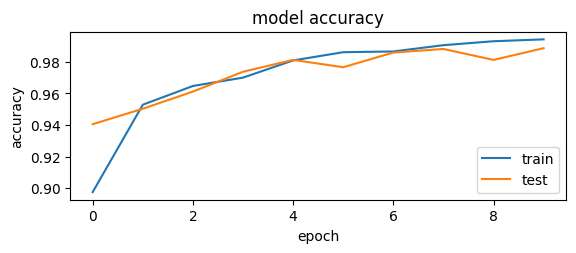

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')




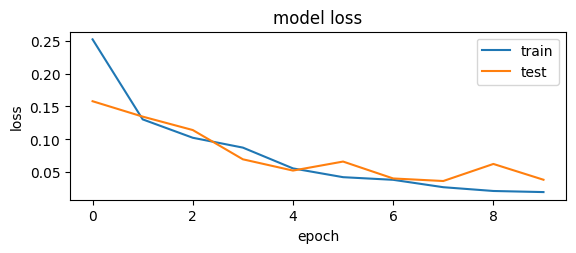

In [ ]:

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
model = load_model("wgru.h5")

In [ ]:
word2vec_model._estimator_type = "classifier"

In [ ]:

y_pred_w2v = model.predict(X_test_padded)

351/351 [==============================] - 51s 142ms/step


In [ ]:
# Convert the predictions to binary values (0 or 1)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred_w2v]

In [ ]:
print(y_pred_w2v.shape)

(11225, 1)


In [ ]:
# Evaluate the Word2Vec model with GRU on the test dataset
loss, accuracy = word2vec_model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Accuracy of Word2Vec model with GRU on test dataset: {accuracy:.4f}")

Accuracy of Word2Vec model with GRU on test dataset: 0.9945


**Apply Glove Embeddings**

In [ ]:
# Load the pre-trained GloVe model
glove_file = '/content/gdrive/MyDrive/glove.6B.200d.txt'

In [ ]:
glove_dict = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = coefs

In [ ]:
# Create the embedding matrix for the words in the dataset
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


**Apply GRU Model**

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.layers import Dropout
def build_glove_model():
    model = Sequential([
        Embedding(len(tokenizer.word_index)+1, 200, input_length=max_len, weights=[embedding_matrix], trainable=False),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

    # print input shape
    print(f"Input shape: {model.input_shape}")

    # print output shape
    print(f"Output shape: {model.output_shape}")
    return model


In [ ]:
model = build_glove_model()

Input shape: (None, 300)
Output shape: (None, 1)


In [ ]:
# glove_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
glove_model = KerasClassifier(build_fn=build_glove_model, epochs=10, batch_size=256)


In [ ]:
from tensorflow import keras


In [ ]:
# Train the model
history2 = glove_model.fit(X_train_padded, y_train,validation_split=0.3, epochs=10, batch_size=256)

Input shape: (None, 300)
Output shape: (None, 1)
Epoch 1/10
93/93 [==============================] - 336s 4s/step - loss: 0.3420 - accuracy: 0.8537 - val_loss: 0.1101 - val_accuracy: 0.9612
Epoch 2/10
93/93 [==============================] - 333s 4s/step - loss: 0.1037 - accuracy: 0.9612 - val_loss: 0.0980 - val_accuracy: 0.9633
Epoch 3/10
93/93 [==============================] - 335s 4s/step - loss: 0.0987 - accuracy: 0.9657 - val_loss: 0.0726 - val_accuracy: 0.9739
Epoch 4/10
93/93 [==============================] - 335s 4s/step - loss: 0.0568 - accuracy: 0.9810 - val_loss: 0.0643 - val_accuracy: 0.9790
Epoch 5/10
93/93 [==============================] - 336s 4s/step - loss: 0.0294 - accuracy: 0.9903 - val_loss: 0.0498 - val_accuracy: 0.9831
Epoch 6/10
93/93 [==============================] - 338s 4s/step - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.0474 - val_accuracy: 0.9878
Epoch 7/10
93/93 [==============================] - 333s 4s/step - loss: 0.0077 - accuracy: 0.9974 - val_

In [ ]:
# glove_model.save("gloveLstm.h5")
glove_model._estimator_type = "classifier"

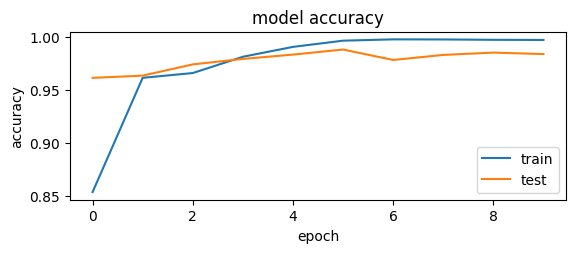

In [ ]:
plt.subplot(2,1,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

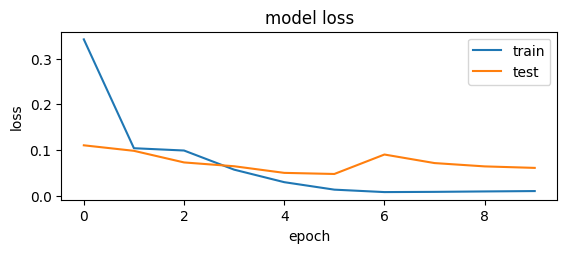

In [ ]:
plt.subplot(2,1,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
# Make predictions on the test set
y_pred_glove = glove_model.predict(X_test_padded)

351/351 [==============================] - 84s 237ms/step


In [ ]:
# Convert the predictions to binary values (0 or 1)
y_pred_binary2 = [1 if pred > 0.5 else 0 for pred in y_pred_glove]

In [ ]:
# Calculate evaluation metrics on the test set
accuracy_gl = accuracy_score(y_test, y_pred_binary2)

In [ ]:
# Print the evaluation metrics
print(f'Lstm Model Accuracy: {round(accuracy_gl*100,2)}%')

Lstm Model Accuracy: 98.7%


In [ ]:
# # Define the ensemble model using hard voting
# # Define the ensemble model
# estimators = [('rf1', rf1),('gb1', gb1), ('lr1', lr1),('word2vec_model',word2vec_model)]
# model_voting = VotingClassifier(estimators=estimators, voting='hard')
# #('model_w2v', word2vec_model),
# # ('glove_model',glove_model)
# #('rf', rf), ('gb', gb),
# #

In [ ]:
# try:
#     filename = 'finalized_model.sav'
#     loaded_model = pickle.load(open(filename, 'rb'))
#     result = loaded_model.score(X_test_transformed, y_test)
#     print(f'Ensemble Learning Accuracy: {round(result*100,2)}%')
# except:
#     Ensemb = VotingClassifier( estimators = [('PAC',PAC),('MultNB',MultNB),('rfc',rfc)], voting = 'hard')
#     Ensemb.fit(tfidf_train,y_train)
#     Ensemb_pred=Ensemb.predict(tfidf_test)
#     filename = 'finalized_model.sav'
#     pickle.dump(Ensemb, open(filename, 'wb'))
#     score4=accuracy_score(y_test,Ensemb_pred)
#     print(f'Ensemble Learning Accuracy: {round(score4*100,2)}%')

In [ ]:
from sklearn.base import is_classifier, is_regressor
models_names=['rf1','gb1','lr1','model_w2v','glove_model']
print("model name\t estimator name\t is_regressor\t is_classifier")
for estimator , model_name in zip([rf1,gb1,lr1,word2vec_model,glove_model],models_names):
        print("{}\t {}   \t {}    \t {}".format(model_name,estimator.__class__.__name__,
                                              is_regressor(estimator),
                                              is_classifier(estimator)
                                              ))
        #rf,gb,,glove_model

model name	 estimator name	 is_regressor	 is_classifier
rf1	 RandomForestClassifier   	 False    	 True
gb1	 GradientBoostingClassifier   	 False    	 True
lr1	 LogisticRegression   	 False    	 True
model_w2v	 KerasClassifier   	 False    	 True
glove_model	 KerasClassifier   	 False    	 True


In [ ]:
from sklearn.ensemble import VotingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
X_train_padded.shape

(33672, 300)

In [ ]:
# model_voting.fit(X_train_padded, y_train)

Input shape: (None, 300)
Output shape: (None, 1)
Epoch 1/10
1053/1053 [==============================] - 487s 460ms/step - loss: 0.1035 - accuracy: 0.9611
Epoch 2/10
1053/1053 [==============================] - 481s 457ms/step - loss: 0.0327 - accuracy: 0.9886
Epoch 3/10
1053/1053 [==============================] - 480s 456ms/step - loss: 0.0171 - accuracy: 0.9940
Epoch 4/10
1053/1053 [==============================] - 480s 455ms/step - loss: 0.0102 - accuracy: 0.9969
Epoch 5/10
1053/1053 [==============================] - 481s 456ms/step - loss: 0.0070 - accuracy: 0.9976
Epoch 6/10
1053/1053 [==============================] - 485s 460ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 7/10
1053/1053 [==============================] - 479s 455ms/step - loss: 0.0035 - accuracy: 0.9988
Epoch 8/10
1053/1053 [==============================] - 481s 457ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 9/10
1053/1053 [==============================] - 484s 459ms/step - loss: 0.0023 - accuracy: 0.99

VotingClassifier(estimators=[('rf1', RandomForestClassifier(random_state=42)),
                             ('gb1',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr1', LogisticRegression(random_state=42)),
                             ('word2vec_model',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f541f511610>)])

In [ ]:
X_test_padded.shape

(11225, 300)

In [ ]:
# import joblib
# joblib.dump(model_voting, 'voting_classifier_model.joblib')

['voting_classifier_model.joblib']

In [ ]:
# import joblib
# model_v = joblib.load('voting_classifier_model.joblib')

In [ ]:
# # X_test_flattened = X_test_padded.reshape(X_test_padded.shape[0], -1)
# tokenizer = Tokenizer()
# X_svd1_list = X_svd1.astype(str).tolist()
# tokenizer.fit_on_texts(X_svd1_list)
# X_test_sequences1 = tokenizer.texts_to_sequences(X_svd1_list)
# X_test_padded1 = pad_sequences(X_test_sequences1, maxlen=max_len)


In [ ]:
# # X_test_padded1 = np.concatenate(X_test_padded).ravel()
# X_test_padded1 = np.reshape(X_test_padded, (1, -1))
# X_test_padded1_reshaped = np.reshape(X_test_padded1, (X_test_padded1.shape[0], -1))[:, :700]
X_svd1_reshaped = X_svd1.reshape((X_svd1.shape[0], -1))
X_svd1_reshaped.dtype

dtype('float64')

In [ ]:
# check the expected input shape of the model_voting
print(f"Expected input shape: {model_voting.named_estimators_['lr1'].coef_.shape}")
# Assuming the LR model object is named 'lr_model'
print(f"Original input shape: {lr1.coef_.shape}")

#X_svd1_reshaped
# check the data type of X_svd1_reshaped
print(f"X_svd1_reshaped data type: {X_svd1_reshaped.dtype}")

Expected input shape: (1, 300)
Original input shape: (1, 148799)
X_svd1_reshaped data type: float64


In [ ]:
# # check the expected input shape of the model_voting
# model_voting.named_estimators_['word2vec_model'].model.summary()

# # check the data type of X_svd1_reshaped
# print(f"X_svd1_reshaped data type: {X_svd1_reshaped.dtype}")
# check the expected input shape and data type of the Word2Vec model
word2vec_model = model_voting.named_estimators_['word2vec_model'].model
print(f"Expected input shape of Word2Vec model: {word2vec_model.input_shape}")
print(f"Data type of Word2Vec model input: {word2vec_model.input.dtype}")

# check the expected input shape and data type of the ensemble model
print(f"Expected input shape of ensemble model: {model_voting.named_estimators_['lr1'].coef_.shape}")
print(f"Data type of ensemble model input: {X_svd1_reshaped.dtype}")



Expected input shape of Word2Vec model: (None, 300)
Data type of Word2Vec model input: <dtype: 'float32'>
Expected input shape of ensemble model: (1, 300)
Data type of ensemble model input: float64


In [ ]:
model_voting.named_estimators_['word2vec_model'].model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 200)          34516000  
                                                                 
 gru_3 (GRU)                 (None, 128)               126720    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,642,849
Trainable params: 126,849
Non-trainable params: 34,516,000
_________________________________________________________________


In [ ]:
X_svd1_reshaped_float32 = X_svd1_reshaped.astype(np.float32)

In [ ]:
X_svd1_reshaped_float32.shape

(11225, 300)

In [ ]:
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Learning Accuracy: {round(accuracy*100,2)}%')

Ensemble Learning Accuracy: 98.47%


**Accurcay Graph of differnt models**

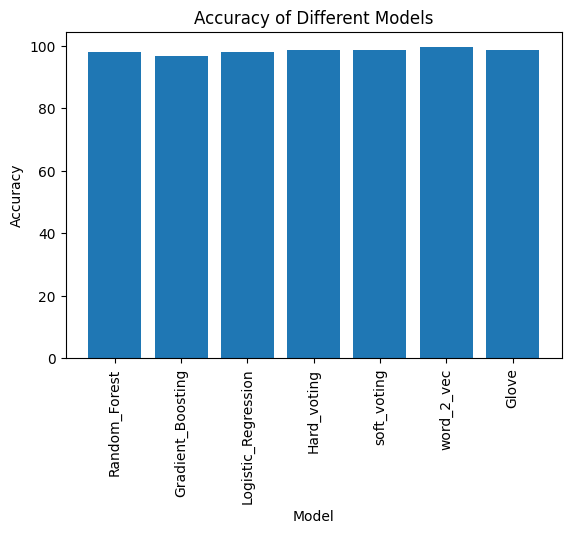

In [ ]:
import matplotlib.pyplot as plt

# Define model names and accuracy scores
model_names = ['Random_Forest', 'Gradient_Boosting', 'Logistic_Regression','Hard_voting','soft_voting','word_2_vec','Glove']
accuracy_scores = [97.89, 96.54, 98.08,98.46,98.61,99.45,98.70]

# Create bar chart
plt.bar(model_names, accuracy_scores)
# set the x-axis labels to the model names
plt.xticks(model_names, rotation=90)

# add gaps between the x-axis labels
plt.subplots_adjust(bottom=0.2)
# Set chart title and axis labels
plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Show chart
plt.show()


**cONFUSION Matrix**

<Axes: >

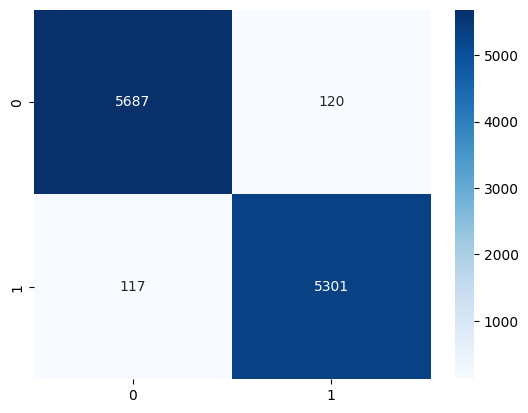

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf1)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


<Axes: >

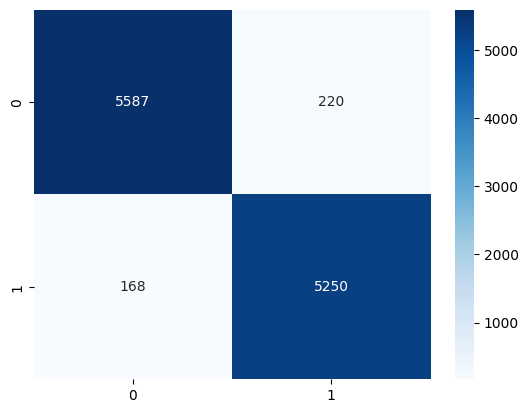

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_gb1)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<Axes: >

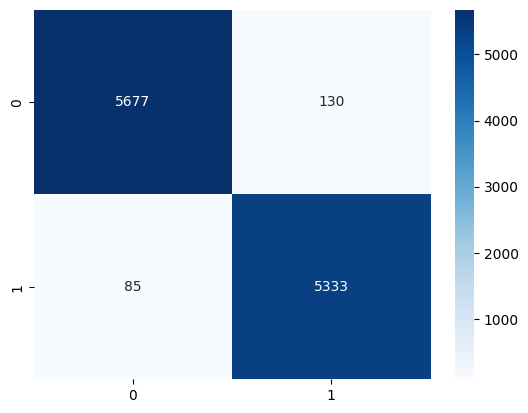

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr1)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<Axes: >

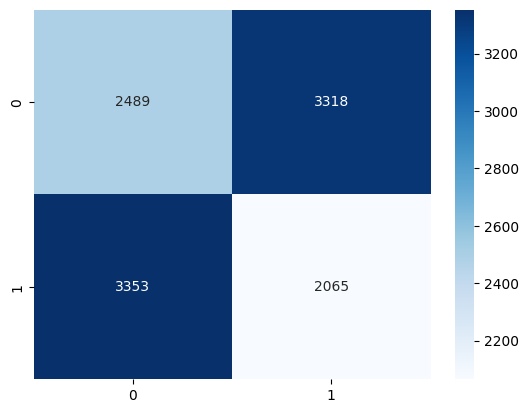

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<Axes: >

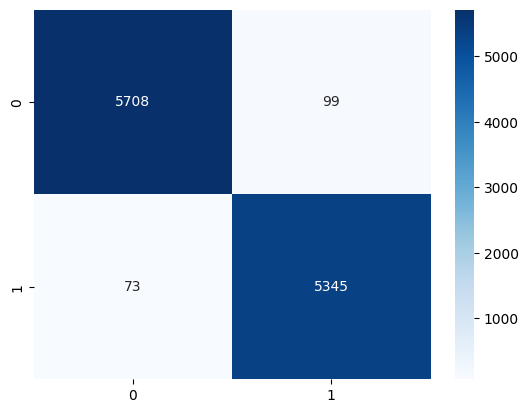

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_soft)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<Axes: >

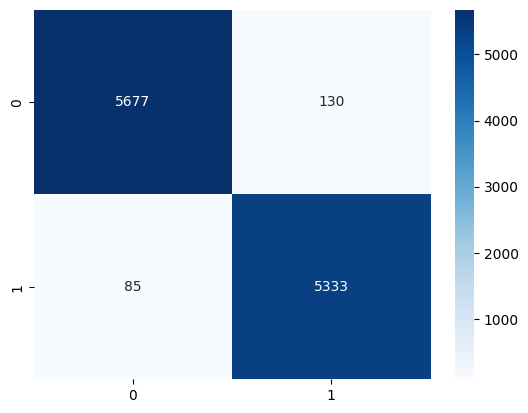

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')